# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import io
from PIL import Image
from IPython.display import Image as IPImage
from IPython.display import display

# Define colors and font sizes
colors = sns.color_palette("hls", 8)
title_size = 24
axis_size = 18
value_size = 16
legend_size = 16


## Exercise 10.1
### Assignment

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Resolution

I chose the second option, which I implemented starting from the GA used in Exercise 09. The main changes are in the `main.cpp` file and in the `vector<Travel> New_generation()` function.

The idea of the Parallel Tempering technique is to consider different systems for simulation in the canonical ensemble, with each system at different temperatures, and allow exchange between system that belong to different termidynamic states. This allows cores with higher temperatures to explore more configurations and systems with lower temperatures to stabilize in a minimum.

In `main.cpp`, according to the rank of the node, I assigned to the system a temperature obtained from a logarithmic scale between $T = \left[0.001; 2\right]$. For my simulation, I used 8 cores with only one individual each nodes.

In `vector<Travel> New_generation()`, I used the genetic operators (implemented in the `Travel Pair_permutation()`, `Travel Shift()`, `Travel Block_permutation()`, and `Travel Inversion()` functions) as trial moves for the Metropolis algorithm, and I accepted the changes with the probability:

$$ A = min\left[ 1; e^{-\frac{L_{new}-L_{old}}{T_i}}\right]$$

where $L_{new}$ and $L_{old}$ are respectively the new and the old cost functions of the individual. The changes are always accepted when the cost function decreases and, when it increases, only with probability $A$, which decreases as the temperature $T_i$ of the node decreases. This allows cores at higher temperatures to explore a wider range of configurations, while cores at lower temperatures can stabilize in the minima of the cost function.

After creating the new individuals, I implemented an exchange of paths among adjacent nodes. Depending on whether the current generation is even or odd, the nodes with even or odd ranks attempt to exchange the path with the previous node with a probability:

$$ A = min\left[ 1; exp\left[\left(L_i-L_j\right)\left(\frac{1}{T_i} - \frac{1}{T_j}\right)\right]\right]$$

I emplemented the parallalization with the MPI library using the functions `MPI_Send` and `MPI_Recv` to send and receive variables:

```cpp
//...//
MPI_Status stat_1, stat_2, stat_3, stat_4;                    // Variable for status
double temp_rec;                                              // Variable for temperature received
double L_rec;                                                 // Variable for cost function received
int tag_temp = 1, tag_L = 2, tag_index = 3, tag_bool = 4;     // Tags for messages
bool check_exchange = false;                                  // Variable indicates exchange 
bool check_rec;                                               // Variable indicates exchange received

if(rank != 0 && rank % 2 == n_gen % 2)
{
    MPI_Send(&temp, 1, MPI_DOUBLE, rank - 1, tag_temp, MPI_COMM_WORLD);                                      // Send temperature
    L_rec = son.L_2();                                                                                       // Cost function
    MPI_Send(&L_rec, 1, MPI_DOUBLE, rank - 1, tag_L, MPI_COMM_WORLD);                                        // Send cost function
    MPI_Send(son.Get_index_cities().data(), son.Get_size(), MPI_INT, rank - 1, tag_index, MPI_COMM_WORLD);   // Send indexes of travel
}

MPI_Barrier(MPI_COMM_WORLD);    // Synchronize all cores

if(rank != size - 1 && rank % 2 != n_gen % 2)
{
    MPI_Recv(&temp_rec, 1, MPI_DOUBLE, rank + 1, tag_temp, MPI_COMM_WORLD, &stat_1);                         // Receive temperature
    MPI_Recv(&L_rec, 1, MPI_DOUBLE, rank + 1, tag_L, MPI_COMM_WORLD, &stat_2);                               // Receive cost function
    vector<int> index_rec(son.Get_size());
    MPI_Recv(index_rec.data(), son.Get_size(), MPI_INT, rank + 1, tag_index, MPI_COMM_WORLD, &stat_3);       // Receive indexes of travel
    // Exchange of paths between processes
    double A = min(1., exp(-(1. / temp - 1. / temp_rec)*(L_rec - son.L_2())));   // Transition probability 
    if (rn.Rannyu() < A)
    {
        check_exchange = true;
        MPI_Send(son.Get_index_cities().data(), son.Get_size(), MPI_INT, rank + 1, tag_index, MPI_COMM_WORLD);   // Send indexes of travel    
        son.Set_index_travel(index_rec);  // Set new travel
    }       
    MPI_Send(&check_exchange, 1, MPI_LOGICAL, rank + 1, tag_bool, MPI_COMM_WORLD);                            // Send temperature
}
    
if(rank != 0 && rank % 2 == n_gen % 2)
{
    MPI_Recv(&check_rec, 1, MPI_LOGICAL, rank - 1, tag_bool, MPI_COMM_WORLD, &stat_4);                         // Receive temperature
    if(check_rec)
    {
        vector<int> index_rec(son.Get_size());
        MPI_Recv(index_rec.data(), son.Get_size(), MPI_INT, rank - 1, tag_index, MPI_COMM_WORLD, &stat_3);       // Receive indexes of travel
        son.Set_index_travel(index_rec);  // Set new travel
    }
}
MPI_Barrier(MPI_COMM_WORLD);    // Synchronize all cores
//...//
'''

Using parallel tempering, the cost function decreases rapidly in the first generations and then saturates slowly before reaching the minimal path. For this reason, I used a high number of generations, $N_{gen} = 30000$. However, the cost function saturates so slowly that at $N_{gen} = 20000$, the best path is very similar to the one at the end of the simulation. This saturation is likely due to the fact that near the best path, there is a very low probability, resulting from the high number of cities, that the appropriate mutation to decrease the cost function occurs.

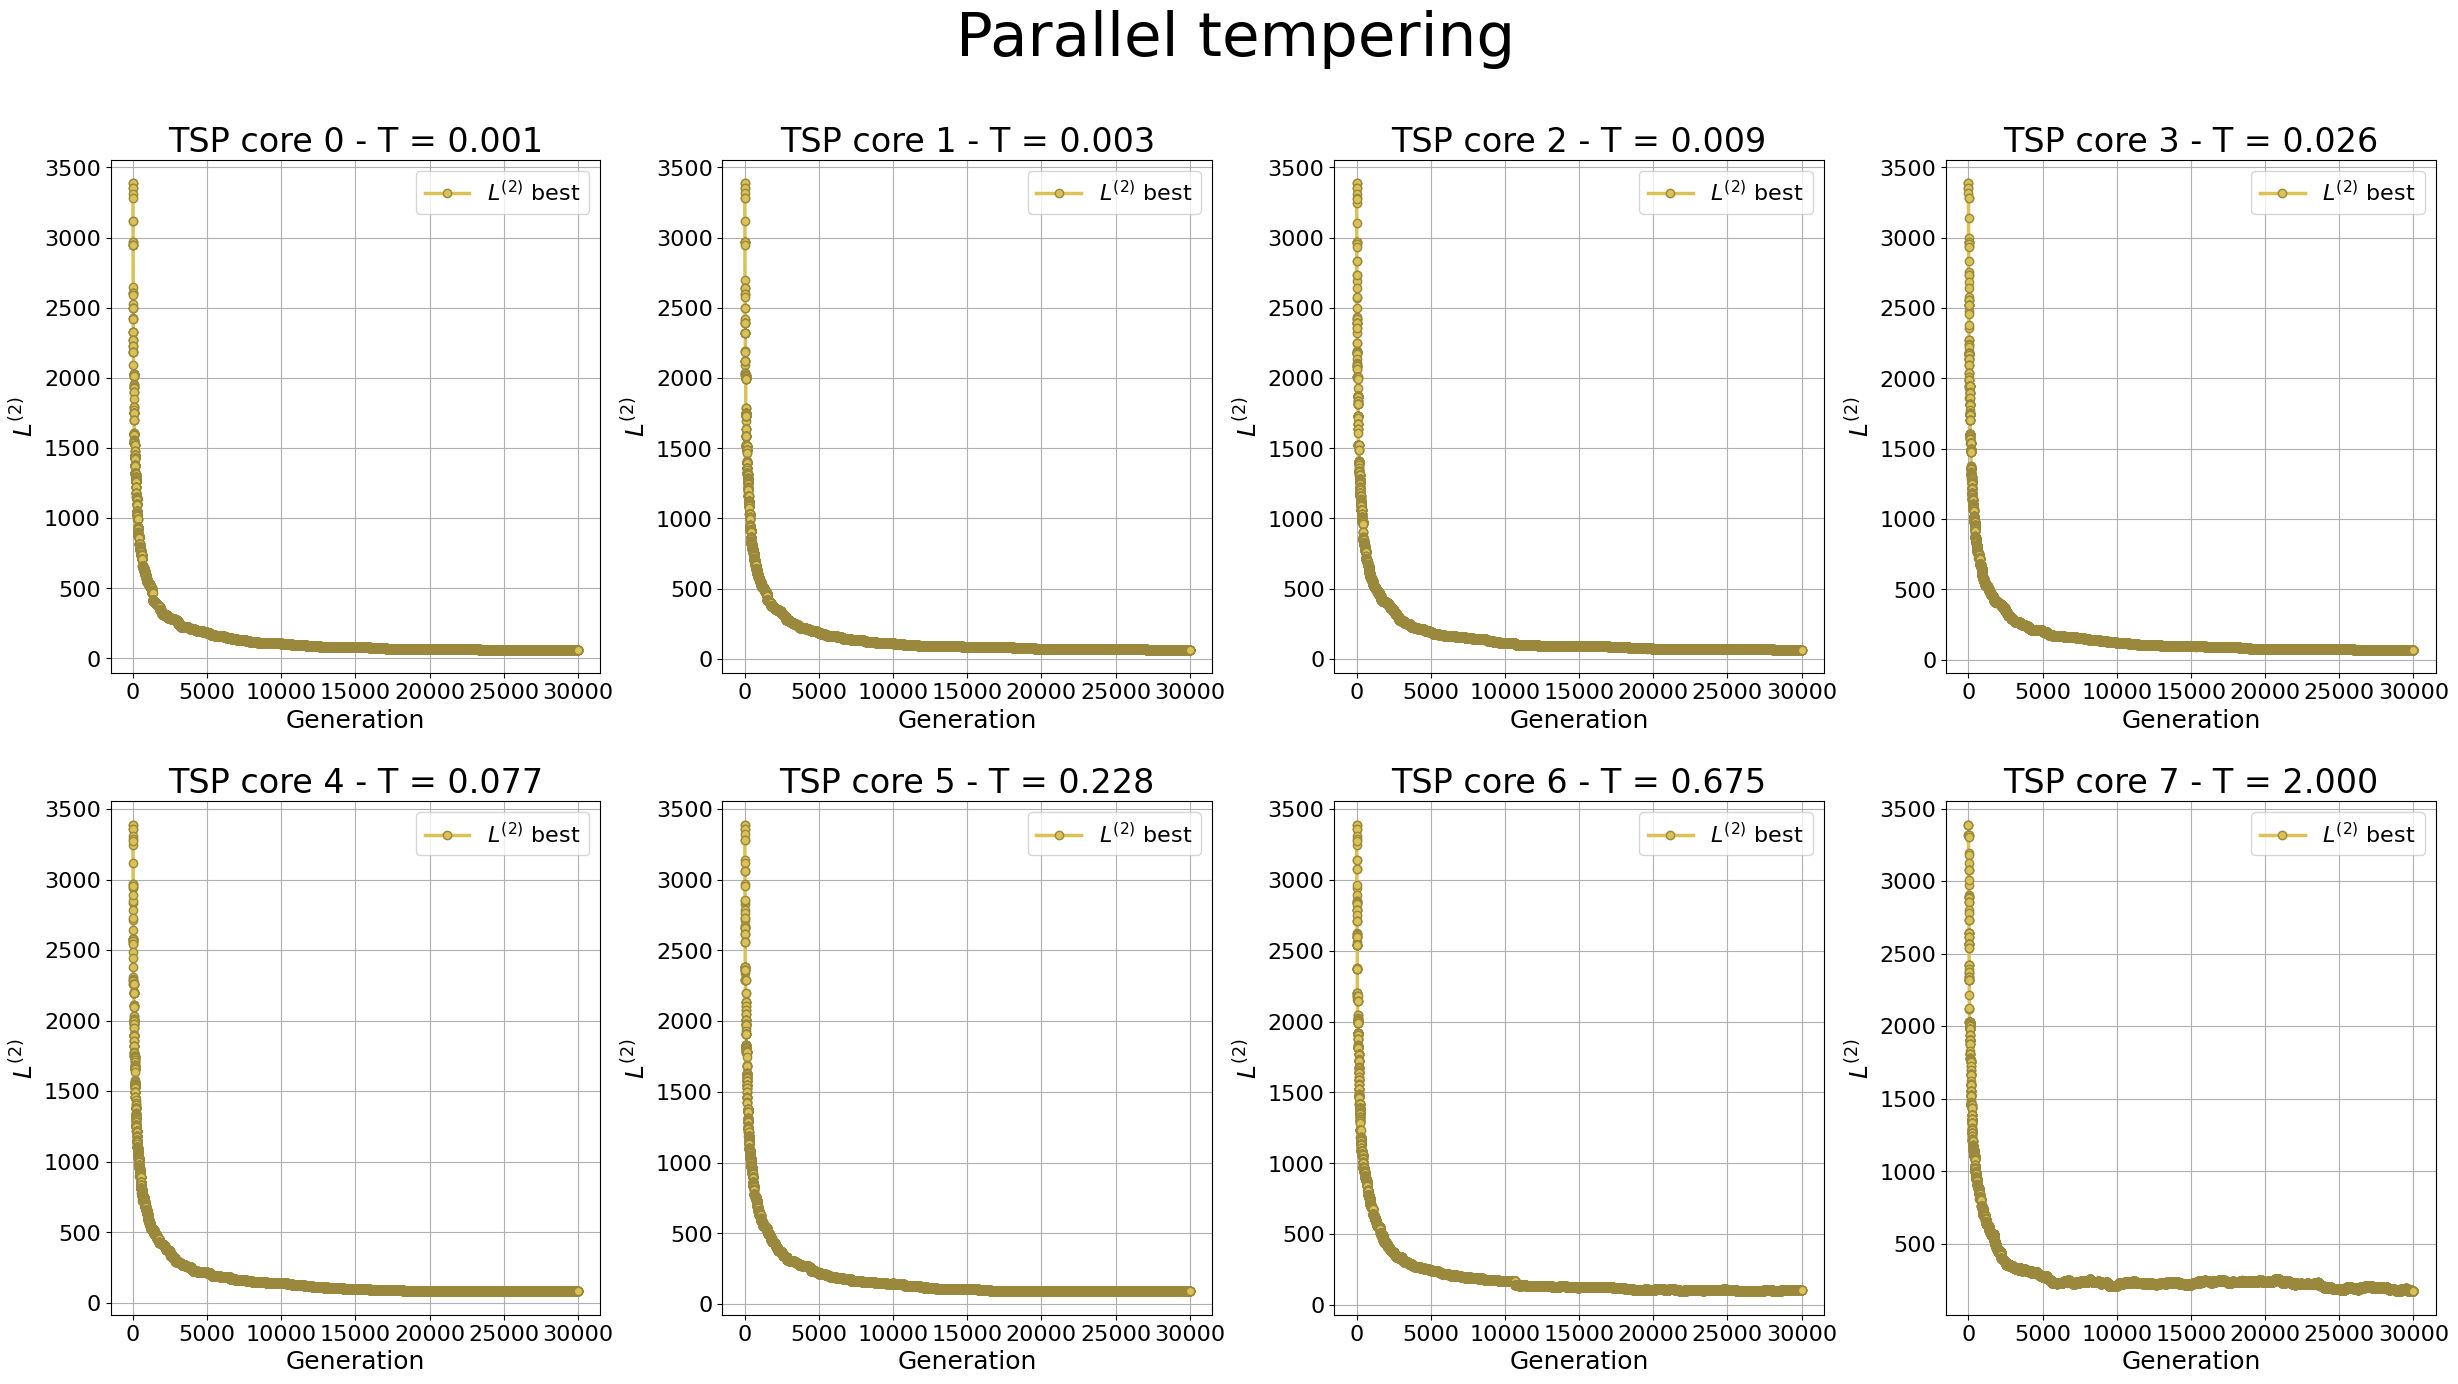

In [37]:
# Create a figure with specified size
plt.figure(figsize=(30, 15))

# Logarithmic scale of temperature
T = np.logspace(np.log10(0.001), np.log10(2), num=8)

# Loop over data files to create subplots
for i in range(8):
    # Data import
    df = pd.read_csv('../E10/Parallel/L_' + str(i) + '.dat', delimiter=' ', index_col=False)
    
    # Create a subplot
    plt.subplot(2, 4, i + 1)
    
    # Plot the data
    plt.plot(df['Gen'], df['L'], color=colors[1], linewidth=2.5, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label=r"$L^{(2)}$ best")
    
    # Set title and labels for each subplot
    plt.title(f"TSP core {i} - T = {T[i]:.3f}", fontsize=title_size)
    plt.xlabel(r'Generation', fontsize=axis_size)
    plt.ylabel(r'$L^{(2)}$', fontsize=axis_size)
    
    # Customize tick parameters and add legend
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.legend(fontsize=legend_size)
    plt.grid(True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Add a main title to the entire figure
plt.suptitle("Parallel tempering", fontsize = title_size + 20)

# Show the plot
plt.show()


As shown in the plot and in the GIF, the best path obtained at the node with the lowest temperature has some crossings, indicating that it isn't the optimal path possible, but is very close. 

/home/sana/miniconda3/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


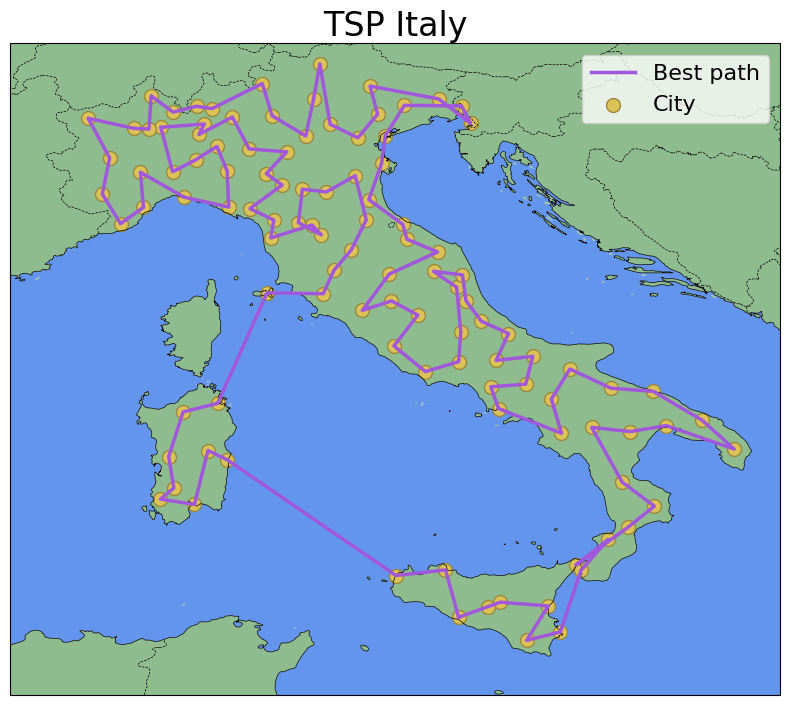

In [5]:
# Create the figure and axis with a geographic projection
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([6, 19, 36, 47], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)

# Plot TSP 
df = pd.read_csv('../E10/Parallel/Travels/30000.dat', delimiter=' ', index_col=False)
ax.plot(df['x'], df['y'], color=colors[6], linewidth=2.5, label="Best path")
ax.scatter(df['x'], df['y'], color=colors[1], marker='o', s=100, edgecolors=tuple(np.array(colors[1]) * 0.7), label="City")

# Add title and legend
plt.title("TSP Italy", fontsize=title_size)
ax.set_xlabel(r'$x$', fontsize=axis_size)
ax.set_ylabel(r'$y$', fontsize=axis_size)
ax.tick_params(axis='both', which='major', labelsize=value_size)
ax.grid(True)
ax.legend(fontsize=legend_size)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [6]:
import warnings

# Ignore warning
warnings.filterwarnings("ignore", ".*facecolor will have no effect as it has been defined as \"never\".*")

frames = []  # List to store individual frames

for i in range(0, 30000, 100):  # Loop over generations
    # Create the figure and axis with a geographic projection
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([6, 19, 36, 47], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.OCEAN, facecolor='cornflowerblue')
    ax.add_feature(cfeature.LAND, facecolor='darkseagreen')
    ax.add_feature(cfeature.COASTLINE, color='black', lw=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='cornflowerblue', linewidth=0.3)

    # Plot TSP inside square
    df = pd.read_csv(f'../E10/Parallel/Travels/{i:04d}.dat', delimiter=' ', index_col=False) 
    ax.plot(df['x'], df['y'], color = colors[6], linewidth=3, label=f"Best path gen. {i}")
    ax.scatter(df['x'], df['y'], color=colors[1], marker='o', s=100, edgecolors=tuple(np.array(colors[1]) * 0.7), label="City")

    # Add title and legend
    plt.title("TSP Italy", fontsize=title_size)
    ax.set_xlabel(r'$x$', fontsize=axis_size)
    ax.set_ylabel(r'$y$', fontsize=axis_size)
    ax.tick_params(axis='both', which='major', labelsize=value_size)
    ax.grid(True)
    ax.legend(fontsize=legend_size)

    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.subplots_adjust(wspace=0.3)
    
    # Convert the plot to PIL Image object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    frames.append(img)
    plt.close()

plt.subplots_adjust(wspace=0.6)

# Save the frames as a GIF
animation_path = "../E10/Parallel/animation.gif"
frames[0].save(animation_path, save_all=True, append_images=frames[1:], optimize=False, duration=100, loop=0)

#display(IPImage(filename=animation_path)) 

<Figure size 640x480 with 0 Axes>

![Example GIF](../E10/Parallel/animation.gif)

I also implemented a parallel tempering code in the `Parallel_2` directory, using a multiple (3 in the case plotted) of 8 temperatures evenly divided among the 8 cores, resulting in a total of 24 temperatures. Similarly to what I did in the parallel tempering with only 8 temperatures, I implemented exchanges between nearby temperatures.

As shown in the plot, where I displayed the cost function of the cores, this approach does not significantly improve the performance of the algorithm: the cost function decreases slightly more rapidly in the first generations but saturates as before after this initial phase. I also experimented with different numbers of temperatures, but the results did not change much.

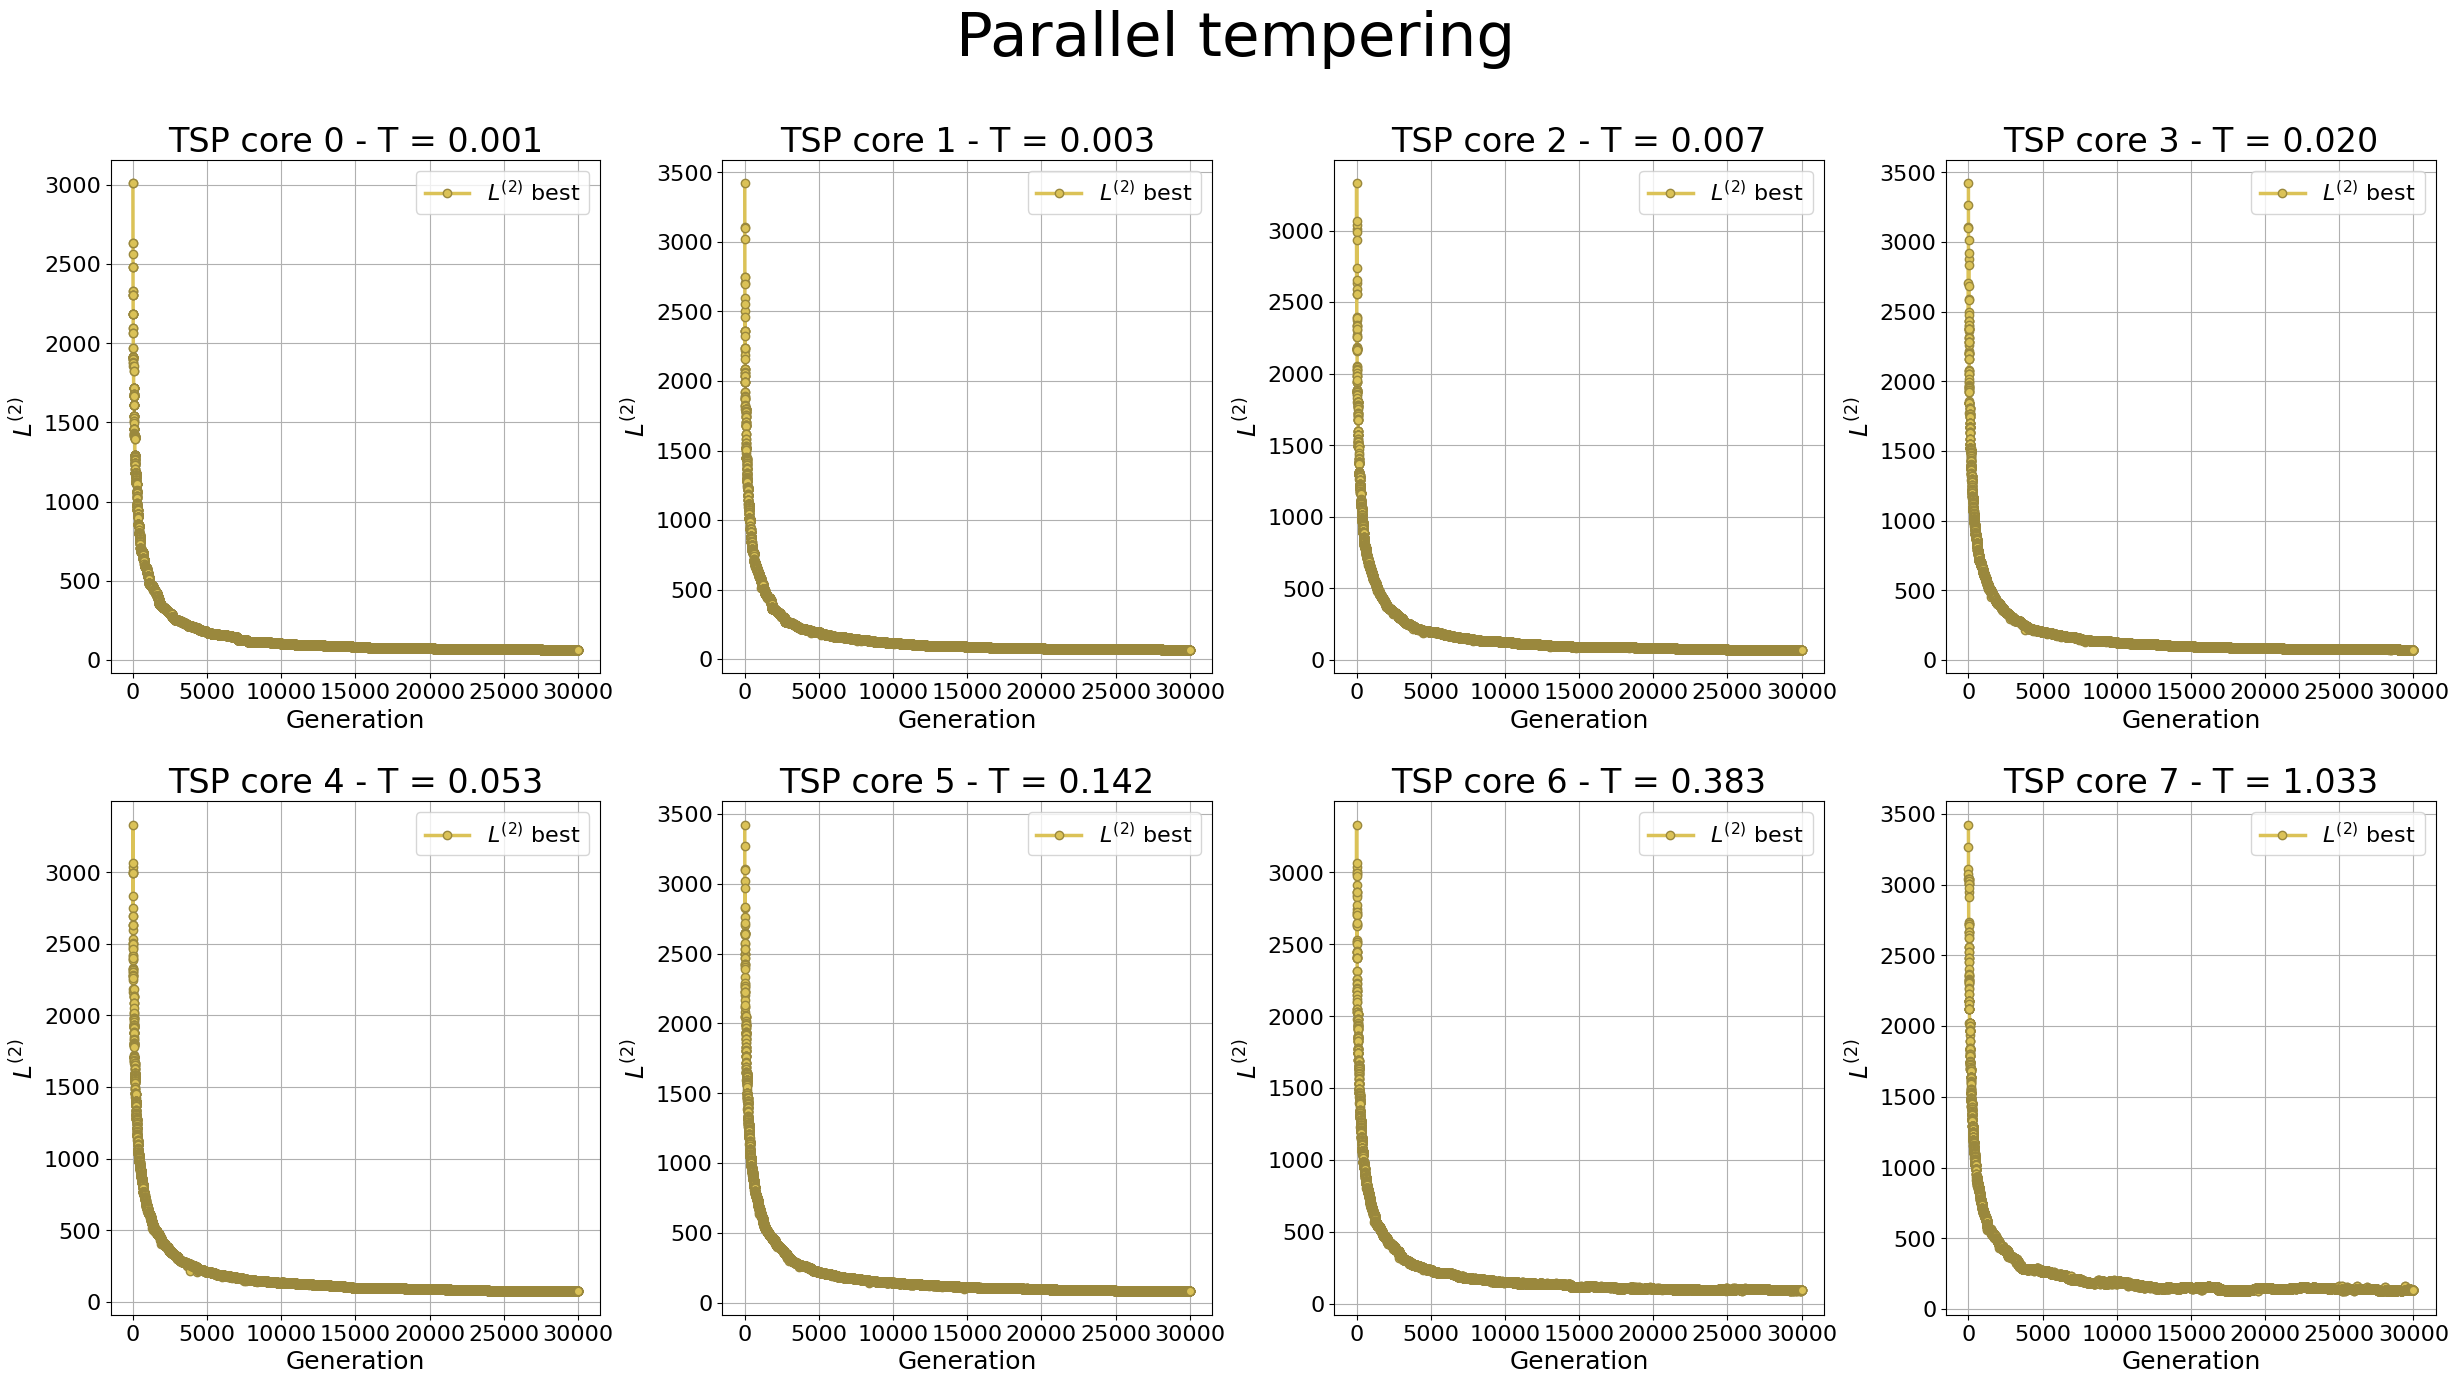

In [42]:
# Create a figure with specified size
plt.figure(figsize=(30, 15))

# Logarithmic scale of temperature
T = np.logspace(np.log10(0.001), np.log10(2), num=8* 3)

# Loop over data files to create subplots
for i in range(8):
    # Data import
    df = pd.read_csv('../E10/Parallel_2/L_' + str(i) + '.dat', delimiter=' ', index_col=False)
    
    # Create a subplot
    plt.subplot(2, 4, i + 1)
    
    # Plot the data
    plt.plot(df['Gen'], df['L'], color=colors[1], linewidth=2.5, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label=r"$L^{(2)}$ best")
    
    # Set title and labels for each subplot
    plt.title(f"TSP core {i} - T = {T[i * 3]:.3f}", fontsize=title_size)
    plt.xlabel(r'Generation', fontsize=axis_size)
    plt.ylabel(r'$L^{(2)}$', fontsize=axis_size)
    
    # Customize tick parameters and add legend
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.legend(fontsize=legend_size)
    plt.grid(True)

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Add a main title to the entire figure
plt.suptitle("Parallel tempering", fontsize = title_size + 20)

# Show the plot
plt.show()


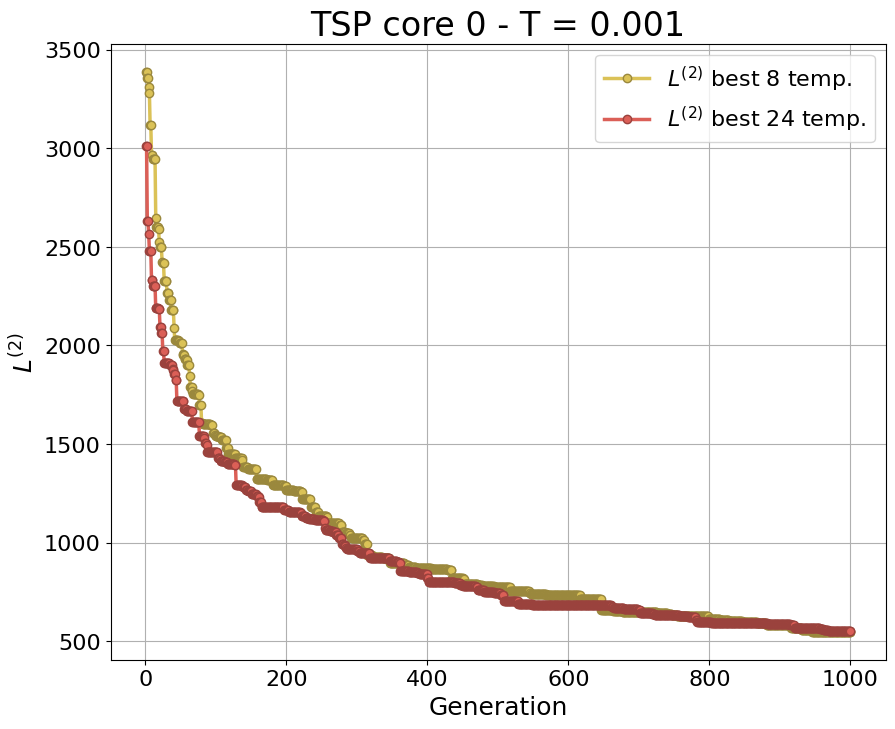

In [52]:
# Create a figure with specified size
plt.figure(figsize=(10, 8))

# Logarithmic scale of temperature
T = np.logspace(np.log10(0.001), np.log10(2), num=8* 3)

# Plot first 1000 generations
df = pd.read_csv('../E10/Parallel/L_0.dat', delimiter=' ', index_col=False)
df_2 = pd.read_csv('../E10/Parallel_2/L_0.dat', delimiter=' ', index_col=False)

# Plot the data
plt.plot(df['Gen'][:1000], df['L'][:1000], color=colors[1], linewidth=2.5, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label=r"$L^{(2)}$ best 8 temp.")
plt.plot(df_2['Gen'][:1000], df_2['L'][:1000], color=colors[0], linewidth=2.5, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label=r"$L^{(2)}$ best 24 temp.")   
# Set title and labels for each subplot
plt.title(f"TSP core 0 - T = {T[0]:.3f}", fontsize=title_size)
plt.xlabel(r'Generation', fontsize=axis_size)
plt.ylabel(r'$L^{(2)}$', fontsize=axis_size)
    
# Customize tick parameters and add legend
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)

# Show the plot
plt.show()


I used the parallel tempering approach for Exercise 09 with points sampled on a circumference and within a square. With the non-parallelized method, I used 100 individuals and 300 generations (for a total of 30000 reproduction processes). The parallelized method is faster: I needed 2500 generations with one individual to reach the best path. Similar to the previous problem, the cost function decreases rapidly in the first generations and then saturates.

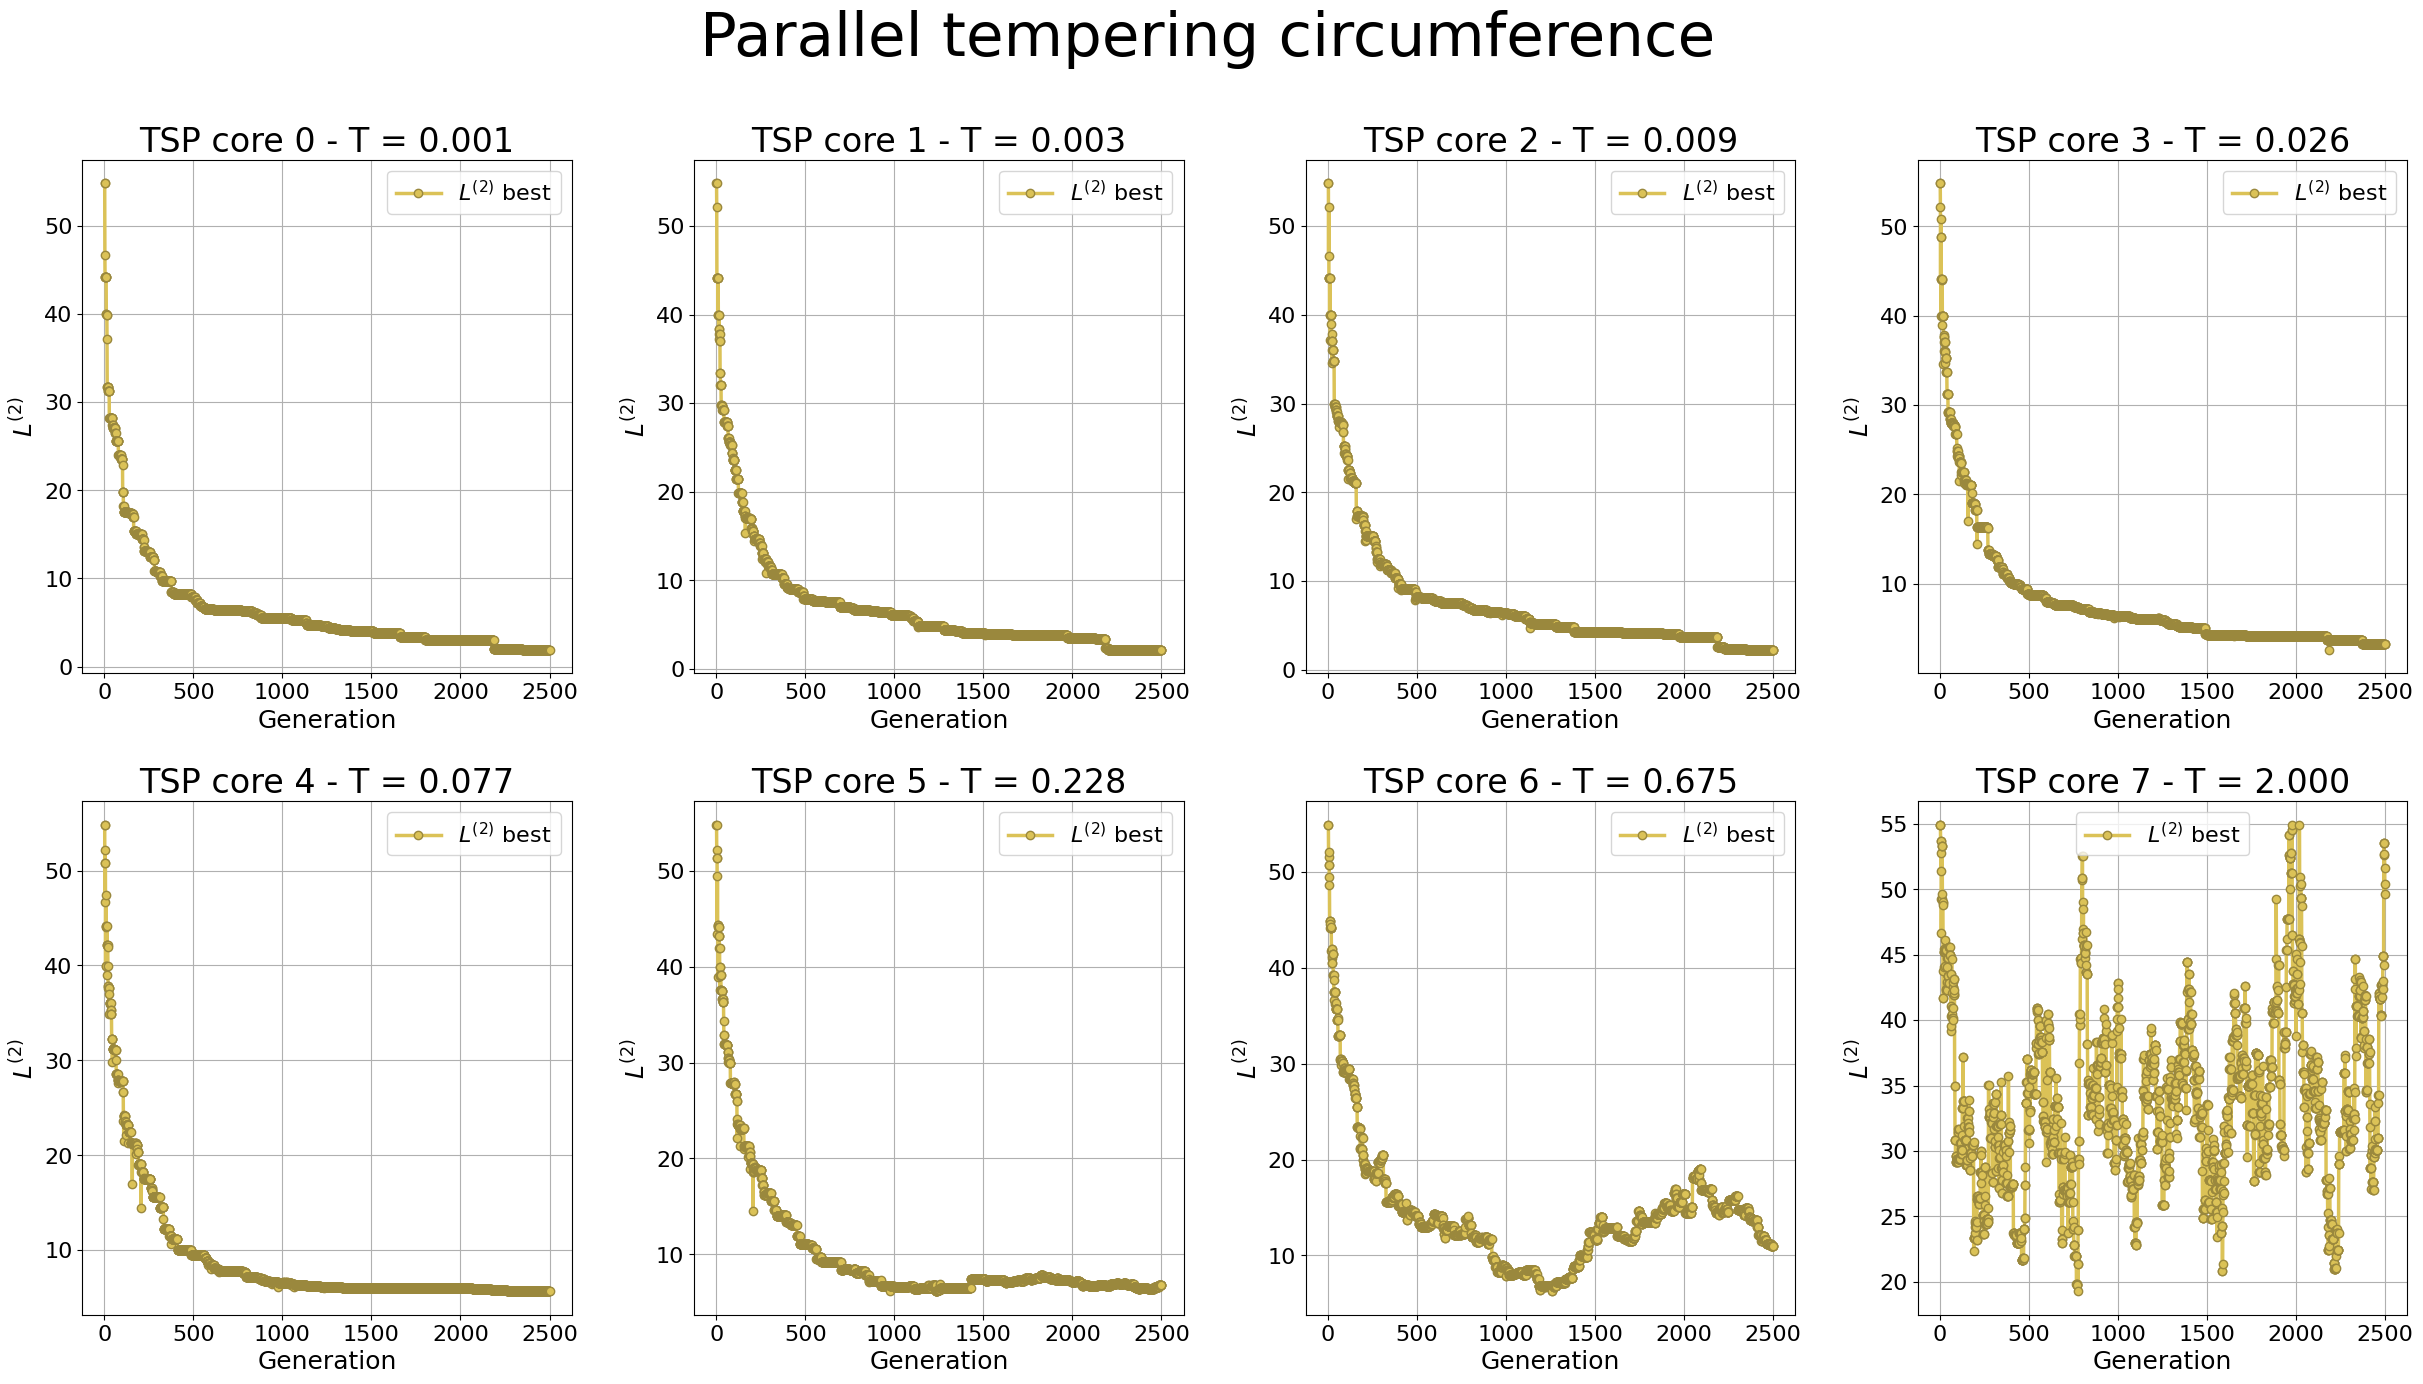

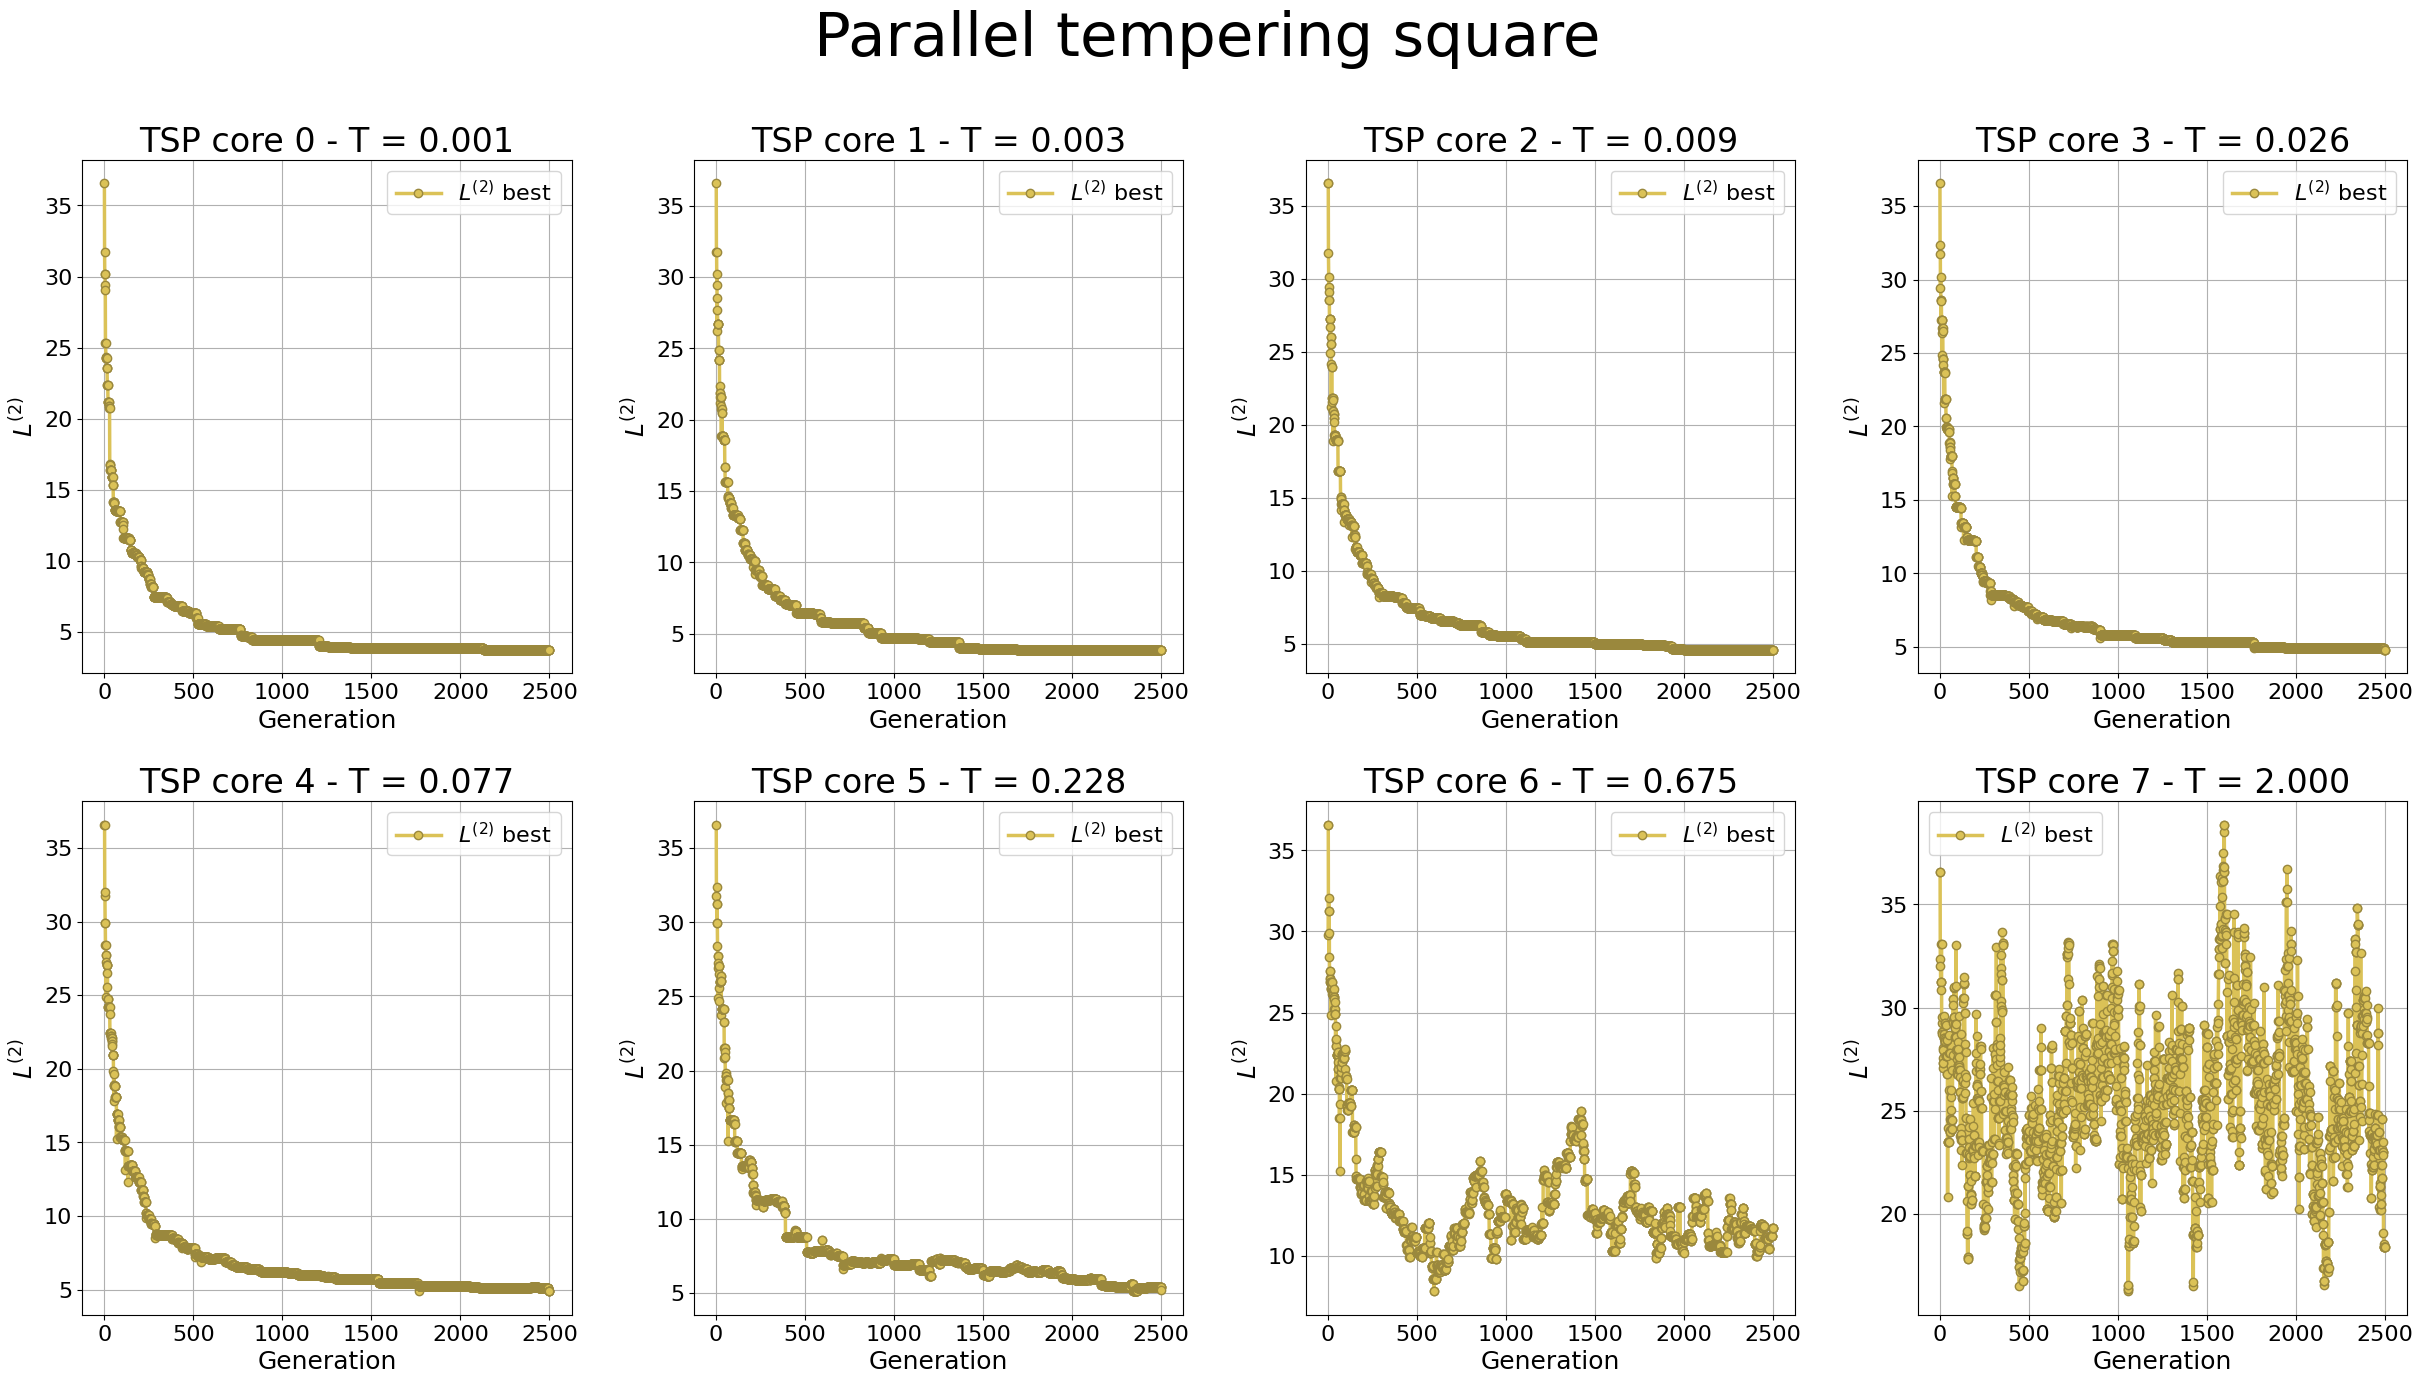

In [99]:
T = np.logspace(np.log10(0.001), np.log10(2), num=8)   # Logarithmic scale of temperature

# Create a figure with specified size


files = ["c", "s"]

for j in range(len(files)):
    plt.figure(figsize=(30, 15))

    # Loop over data files to create subplots
    for i in range(8):
        # Data import
        df = pd.read_csv('../E10/E_09_parallel/L_' + str(files[j]) + '_' + str(i) + '.dat', delimiter=' ', index_col=False)
        
        # Create a subplot
        plt.subplot(2, 4, i + 1)
        
        # Plot the data
        plt.plot(df['Gen'], df['L'], color=colors[1], linewidth=2.5, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label=r"$L^{(2)}$ best")
        
        # Set title and labels for each subplot
        plt.title(f"TSP core {i} - T = {T[i]:.3f}", fontsize=title_size)
        plt.xlabel(r'Generation', fontsize=axis_size)
        plt.ylabel(r'$L^{(2)}$', fontsize=axis_size)
        
        # Customize tick parameters and add legend
        plt.tick_params(axis='both', which='major', labelsize=value_size)
        plt.legend(fontsize=legend_size)
        plt.grid(True)

    # Adjust space between subplots
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

    # Add a main title to the entire figure
    if (j == 0):
        plt.suptitle("Parallel tempering circumference", fontsize = title_size + 20)
    else:
        plt.suptitle("Parallel tempering square", fontsize = title_size + 20)

    # Show the plot
    plt.show()


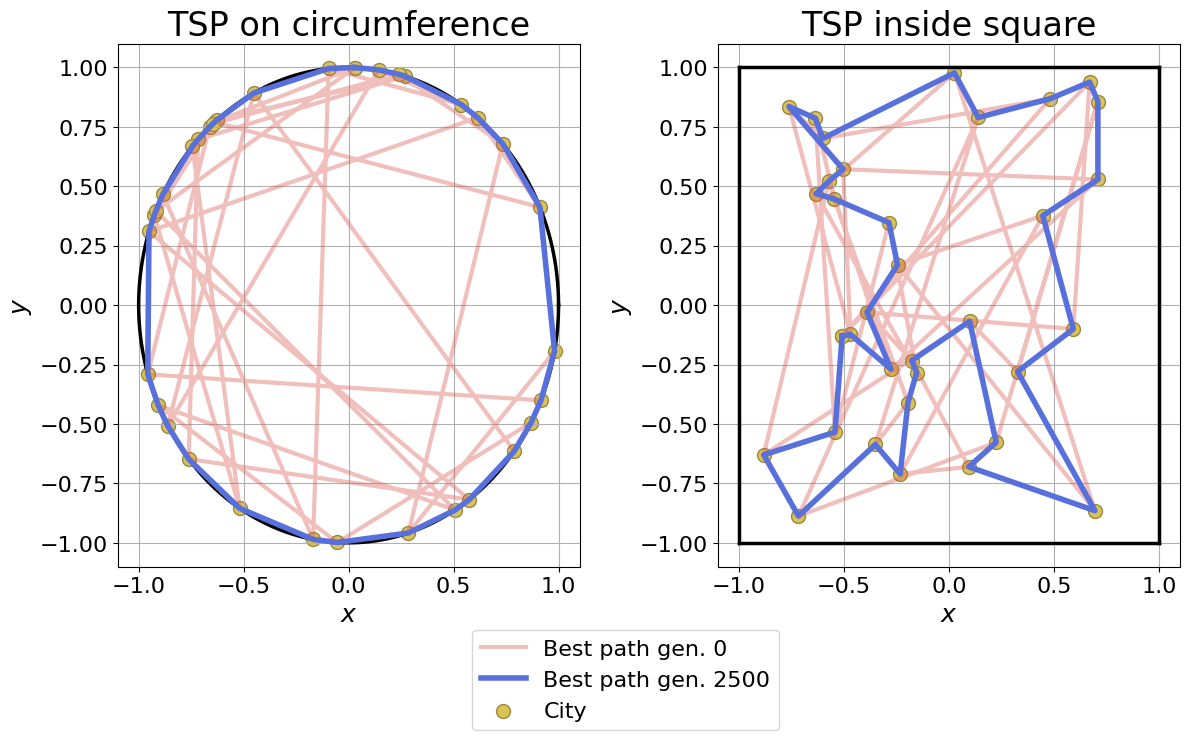

In [98]:
# Create a new figure
plt.figure(figsize=(12, 8))

# Plot TSP on circumference
plt.subplot(1, 2, 1)
df_c = pd.read_csv('../E10/E_09_parallel/Travels_c/0000.dat', delimiter=' ', index_col=False)
N = 1000
x = np.cos(np.linspace(0, 2 * np.pi, N))
y = np.sin(np.linspace(0, 2 * np.pi, N))
plt.plot(x, y, color="k", linewidth=2.5)
line1, = plt.plot(df_c['x'], df_c['y'], color=colors[0], linewidth=3, alpha=0.4, label="Best path gen. 0")
scatter1 = plt.scatter(df_c['x'], df_c['y'], color=colors[1], marker='o', s=100, edgecolors=tuple(np.array(colors[1]) * 0.7), label="City")
df_c = pd.read_csv('../E10/E_09_parallel/Travels_c/2500.dat', delimiter=' ', index_col=False)
line2, = plt.plot(df_c['x'], df_c['y'], color=colors[5], linewidth=4, label="Best path gen. 2500")
plt.title("TSP on circumference", fontsize=title_size)
plt.xlabel(r'$x$', fontsize=axis_size)
plt.ylabel(r'$y$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.grid(True)

# Plot TSP inside square
plt.subplot(1, 2, 2)
df_s = pd.read_csv('../E10/E_09_parallel/Travels_s/0000.dat', delimiter=' ', index_col=False)
plt.plot(df_s['x'], df_s['y'], color=colors[0], linewidth=3, alpha=0.4, label="Best path gen. 0")
plt.scatter(df_s['x'], df_s['y'], color=colors[1], marker='o', s=100, edgecolors=tuple(np.array(colors[1]) * 0.7), label="City")
df_s = pd.read_csv('../E10/E_09_parallel/Travels_s/2500.dat', delimiter=' ', index_col=False)
plt.plot(df_s['x'], df_s['y'], color=colors[5], linewidth=4, label="Best path gen. 2500")
plt.plot([1, 1], [-1, 1], 'k-', linewidth=2.5)
plt.plot([-1, -1], [-1, 1], 'k-', linewidth=2.5)
plt.plot([-1, 1], [1, 1], 'k-', linewidth=2.5)
plt.plot([-1, 1], [-1, -1], 'k-', linewidth=2.5)
plt.title("TSP inside square", fontsize=title_size)
plt.xlabel(r'$x$', fontsize=axis_size)
plt.ylabel(r'$y$', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.grid(True)

# Create a unified legend
lines = [line1, line2, scatter1]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(-0.2, -0.1), fontsize=legend_size, ncol=1)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


## Exercise 10.2
### Assignment

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

### Resolution

To compare the parallel tempering code I implemented with the non-parallel GA code, I simulated using the GA from Exercise 09 with 8 individuals.

This number of individuals is too small for the simulation: the cost function fluctuates and does not decrease. To minimize the cost function, it would be necessary to use more individuals, but this compromises efficiency and increases computational time.

So, the parallel tempering is much more efficient than the non-parallelized method.

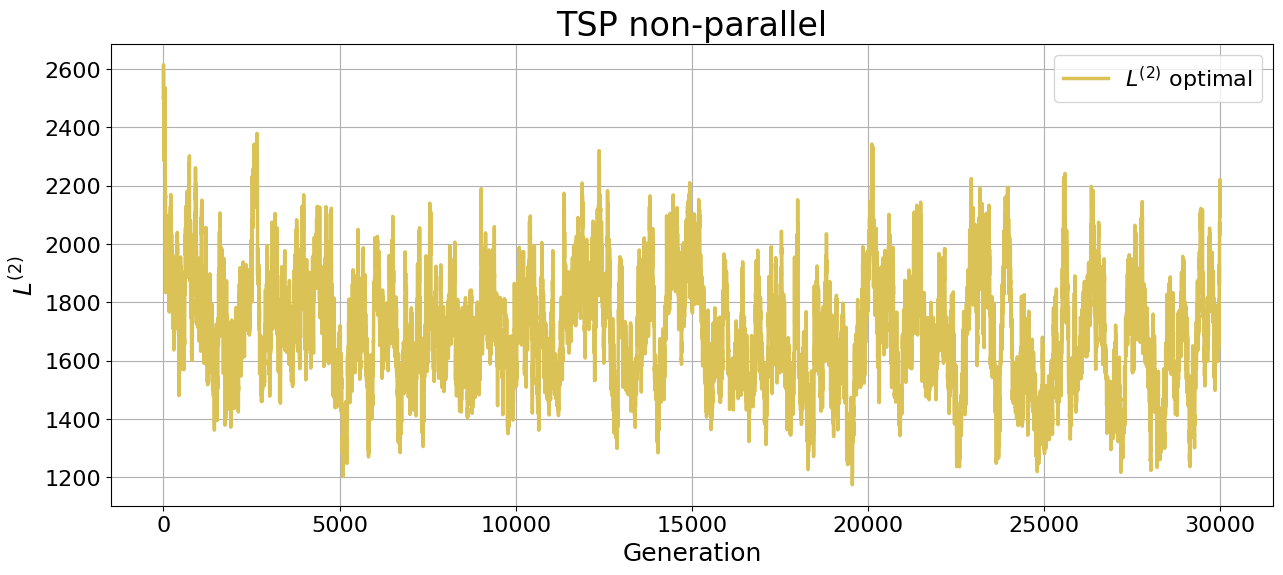

In [51]:
# Create a figure with specified size
plt.figure(figsize=(15, 6))

# Loop over data files to create subplots
df = pd.read_csv('../E10/No_parallel/L.dat', delimiter=' ', index_col=False)
   
    # Plot the data
plt.plot(df['Gen'], df['L'], color=colors[1], linewidth=2.5,  label=r"$L^{(2)}$ optimal")
    
    # Set title and labels for each subplot
plt.title(f"TSP non-parallel", fontsize=title_size)
plt.xlabel(r'Generation', fontsize=axis_size)
plt.ylabel(r'$L^{(2)}$', fontsize=axis_size)
    
    # Customize tick parameters and add legend
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=legend_size)
plt.grid(True)


# Show the plot
plt.show()
